In [1]:
import pandas as pd
import datetime
import tensorflow as tf
import keras
import seaborn
import numpy as np

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from matplotlib import pyplot



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-06-16 09:45:30.400978: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


To do:
* Try K-fold per timeseries instead of timestep and shuffle
* Make overview of smape scores in validation
* Experiment with regularization
* Experiment  with different window size
* Smoothing
voor volgende keer:
shuffel moet de dataframes returenen dan kunnen die door df_to_observations heen
dan krijg je dus train_observations en validation_observation en daar kunnen dan x_train en y_trian uit gehaald worden
eerst wel y_validation_final er uit halen

In [2]:
# Create fixed-window sequences for training and validation data
def create_sequences(X, window_size):
    seq_X = []
    seq_y = []
    for i in range(len(X) - window_size):
        seq_X.append(X[i:i+window_size])
        seq_y.append(X[i+window_size])
    return seq_X, seq_y

In [3]:
def reprocess(y, details):
    # print(details)
    mean = details[2][0]
    std = details[2][1]
    PF = details[2][2]
    PFtype = details[2][3]
    time = details[3]

    # print("mean:", mean, "std:", std, "PF", PF, "type", PFtype, "time", time)

    if(PFtype == 1):
        return ((y * std) + mean) * np.exp(PF[0] * time + PF[1])    
    # print("here")
    return (y * std + mean) * (PF[0] * np.square(time) + PF[1] * time + PF[2])


In [106]:
def preprocess(data):
    PFtype = -1
    PF1 = np.polyfit(np.linspace(0,len(data) - 1,num=len(data)), np.log(data), 1)
    PF2 = np.polyfit(np.linspace(0,len(data) - 1,num=len(data)),data, 2)
    error1 = data - (np.exp(PF1[0] * np.linspace(0, len(data) - 1, num=len(data)) + PF1[1]))
    error2 = data - (PF2[0] * np.square(np.linspace(0,len(data) - 1,num=len(data))) + PF2[1] * np.linspace(0, len(data) - 1, num=len(data)) + PF2[2])
    
    #Otto: dit is de keuze voro welke je preporcessed. je kan die plotjes un commenten om de fit te zien
    if(np.sum(np.square(error1)) < np.sum(np.square(error2))):
        PF = PF1
        preprocessed = data / (np.exp(PF[0] * np.linspace(0,len(data) - 1,num=len(data)) + PF[1]))
        PFtype = 1
    else:
        PF = PF2
        preprocessed = data / (PF2[0] * np.square(np.linspace(0,len(data) - 1,num=len(data))) + PF2[1] * np.linspace(0,len(data) - 1,num=len(data)) + PF2[2])
        PFtype = 2
    
    m = np.mean(preprocessed)
    s = np.std(preprocessed)
    preprocessed = (preprocessed - m)/s
    details = [m, s, PF, PFtype]
    
    return preprocessed, details

In [6]:
def smape_clean(y_true, y_pred):
    smape = 100 * np.mean(2*np.abs(y_pred - y_true) / (y_true + y_pred))
    return smape

In [7]:
def smape(model, validation):
    validation_x = []
    validation_y = []
    for val in validation:
        validation_x.append(val[0])
        validation_y.append(val[1])
    validation_x = np.array(validation_x)
    validation_y = np.array(validation_y)
    smape = 0
    prediction = model.predict(validation_x, verbose=0)
    # _, acc = model.evaluate(validation_x, validation_y, verbose = 0)

    # print("sse val is; ", np.sum(np.square(validation_y - prediction))/len(validation_y), "val is ", acc)
    for i in range(len(validation)):
        observation = validation[i]
        pred = prediction[i]
        #print(pred, observation[1], pred - observation[1])
        x_hat = reprocess(pred, observation)
        x = reprocess(observation[1], observation)
        #print(x_hat, x, x_hat - x)

        smape += 2*np.abs(x_hat-x)/(x+x_hat)

    smape /= len(validation)
    smape *=100

    return smape

In [8]:
def build_model(x_train, y_train, x_validation, y_validation, window_size, options): #x_validation, y_validation
    # Build the FFNN model
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(window_size, 1))) 
    model.add(keras.layers.Dense(options.layers[0], activation='sigmoid'))

    if len(options.layers) > 2:
        for i in range(1,len(options.layers)-1):
            model.add(keras.layers.Dense(options.layers[i], activation=options.activation))
                
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    #early stopping and saving the best model SOURCE: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50, min_delta=0.001)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
    # fit model

    # Train the model
    history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=options.batchSize, verbose = 0, callbacks=[es, mc], epochs= 1000) #fit the model with early stop

    ##this is the best model
    saved_model = load_model("best_model.h5")

    _, train_acc = saved_model.evaluate(x_train, y_train, verbose = 0)
    _, test_acc = saved_model.evaluate(x_validation, y_validation, verbose = 0)

    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

    # plot the different accuracies. maybe then dont do a early stop. 
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    return saved_model

In [9]:
df = pd.read_excel("M3C.xls")
df = df.iloc[:146,6:26]

df_train = df.iloc[:,:14]
df_test = df.iloc[:,14:]

window_size = 3

In [10]:
def df_to_observations(data, window_size):
    observations = []
    details = []
    for index, row in data.iterrows():
        preprocessed, detail = preprocess(np.array(row))
        details.append(detail)
        for i in range(len(preprocessed) - window_size):
            observations.append([preprocessed[i:i+window_size],preprocessed[i+window_size], detail, i+window_size])

    return observations

In [47]:
def shuffle(data, v): 
    np.random.shuffle(np.array(data) )

    train = data[:int(np.floor(len(data)*(1-v)))]
    validation = data[int(np.floor(len(data)*(1-v))):]

    return pd.DataFrame(train), pd.DataFrame(validation)

In [109]:
def preprocess_and_split(data, v):
    prep = []
    details_list = []  # Rename the variable to avoid overwriting
    validationSet = []
    for index, row in data.iterrows():
        p, details = preprocess(row)
        prep.append(p)
        for i in range(len(p) - window_size):
            validationSet.append([p[i:i+window_size], p[i+window_size], details, i+window_size])
    data = np.array(prep).reshape(data.shape)
    train = data[:int(np.floor(len(data)*(1-v)))]
    validation = data[int(np.floor(len(data)*(1-v))):]

    return train, validation, validationSet

In [49]:
def get_folds(rows, k):
    folds = []
    rows = np.array_split(np.arange(rows), k)
    for row in rows:
        folds.append(row[-1])
    return folds

In [112]:
def kfolds(df_train, k, options, fold_type, window_size):
    avgSmape = []
    train, final_validation = shuffle(df_train, 0.1) #Shuffled Dataframes
    folds = get_folds(len(train), k) #Indicates the points to which data should be used in every fold
    for fold in folds:
        if fold_type == 1: # Check this section
            observations = df_to_observations(df_train, window_size)
            validationSet = []
            x_train = []
            y_train = []
            for i in range(0, len(observations), (14 - window_size)):
                validationSet.append(observations[fold + i])
                #print("appended to validation set obseravtion", observations[fold + i])
                #print("appended to train set observation ", end="")
                for j in range(fold):
                    #print(observations[j + i][0], observations[j + i][1] )
                    x_train.append(observations[j + i][0])
                    y_train.append(observations[j + i][1])
                #print()
            x_train = np.array(x_train)
            y_train = np.array(y_train)
        
            x_validation = []
            y_validation = []
            for valObs in validationSet:
                x_validation.append(valObs[0])
                y_validation.append(valObs[1])
            x_validation = np.array(x_validation)
            y_validation = np.array(y_validation)
        elif fold_type == 2:
            x_train = []
            y_train= []
            fold_train, fold_validation, validationSet = preprocess_and_split(train.iloc[:fold],0.1,) #takes df's returns np arrays
            for i in range(len(fold_train)):
                for j in range(train.shape[1]- window_size):
                    x_train.append(fold_train[i][j:j+window_size])
                    y_train.append(fold_train[i][j+window_size])

            x_train = np.array(x_train).reshape(len(x_train),window_size)
            y_train = np.array(y_train).reshape(len(y_train))

            x_validation = []
            y_validation = []

            for i in range(len(fold_validation)):
                for j in range(train.shape[1]- window_size):
                    x_validation.append(fold_validation[i][j:j+window_size])
                    y_validation.append(fold_validation[i][j+window_size])

            x_validation = np.array(x_validation).reshape(len(x_validation),window_size)
            y_validation = np.array(y_validation).reshape(len(y_validation))

        model = build_model(x_train, y_train, x_validation, y_validation, window_size, options)

        validationPrediction = model.predict(x_validation, verbose=0)
        yHatReal = []
        yReal = []

        for i in range(len(y_validation)):
            yReal.append(reprocess(y_validation[i], validationSet[i]))
            yHatReal.append(reprocess(validationPrediction[i], validationSet[i]) )
        smapeVal = 0
        for i in range(len(yReal)):
            smapeVal += smape_clean(yReal[i], yHatReal[i])
        smapeVal /= len(yReal)
        print("smape equals", smapeVal, "with", fold, "time step as training")
        avgSmape.append(smapeVal)
    return np.mean(avgSmape), model

Train: 0.720, Test: 0.607


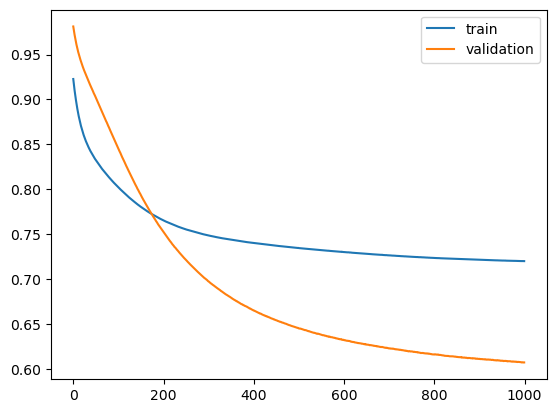

smape equals 10.360844423429985 with 26 time step as training
Train: 0.727, Test: 0.589


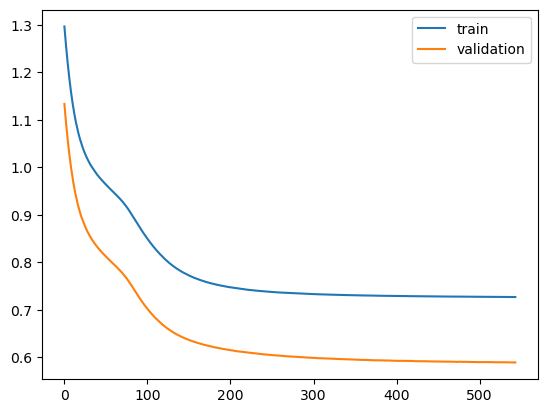

smape equals 9.172427776678832 with 52 time step as training
Train: 0.698, Test: 0.705


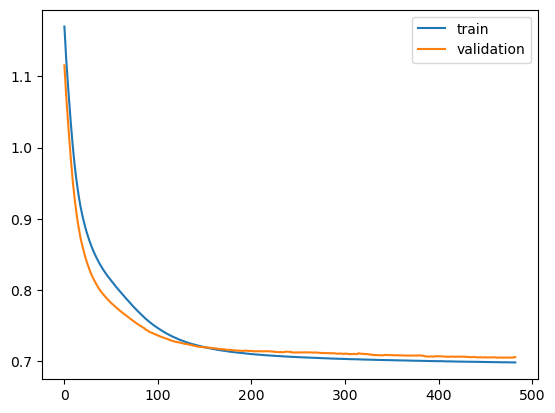

smape equals 11.034103269065037 with 78 time step as training
Train: 0.733, Test: 0.803


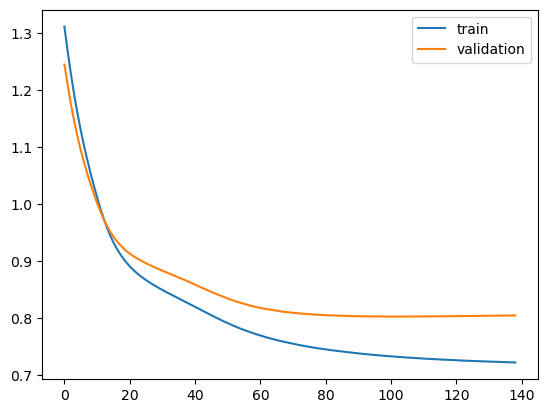

smape equals 12.498883291509403 with 104 time step as training
Train: 0.757, Test: 0.977


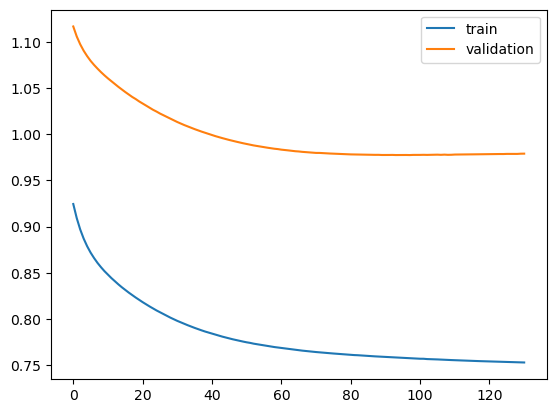

smape equals 11.174326226873555 with 130 time step as training
(10.848116997511362, <keras.engine.sequential.Sequential object at 0x7ff6cd14bee0>)


In [113]:
options = [[[2],'relu',16,0,0]]
options = pd.DataFrame(options)
options = options.set_axis(['layers', 'activation', 'batchSize', 'averageSmape', 'varianceSmape'], axis=1)
# print(options)
window_size = 3
smape = kfolds(df_train, 5, options.iloc[0], 2, window_size)
print(smape)


In [ ]:
lays = [[10], [2,2], [3,2], [4,4,4], [10,10,10]]
epochs = [50]
batchSizes = [16]
activationFunctions = ['relu']

options = []

for layer in lays:
    for activation in activationFunctions:
        for batchSize in batchSizes:
                options.append([layer, activation, batchSize, 0, 0])


options = pd.DataFrame(options)
options = options.set_axis(['layers', 'activation', 'batchSize', 'averageSmape', 'varianceSmape'], axis=1)

# print(options.iloc[0].layers)

for i in range(len(options)):
    smape_avg=[]
    for j in range(1):
        smp, model = kfolds(df_train, [1,2,3,4,5,6,7,8,9,10], options.iloc[i])
        smape_avg.append(smp)

    options.iat[i,3] = np.mean(smape_avg)
    options.iat[i,4] = np.std(smape_avg)


op = pd.DataFrame(options)
res = op.sort_values(by="averageSmape")
print(res)

TypeError: kfolds() missing 2 required positional arguments: 'fold_type' and 'window_size'

In [ ]:
print(op.sort_values(by="averageSmape"))

In [ ]:
##TESTING

predictions = pd.DataFrame()
observations = []
window_size = 3

df_full = pd.DataFrame()
df_full = df_train
df_full = df_full.drop(df_full.columns[14:], axis=1)

num_predictions = 6

# Make predictions using autoregressive approach
for pred in range(num_predictions):

    PF = []
    for index, row in df_full.iterrows():
        preprocessed, details = preprocess(np.array(row))
        PF.append(details[2:])
        observations.append([preprocessed[11+pred:14+pred],0, details, 14+pred]) #y is unknown and first time point to predict is 15(or 14?)`

    # Reshape the input for prediction
    x = []
    for i in (range(len(observations))):
        x.append(observations[i][0])
    x = np.array(x).reshape(len(x),window_size)
    
    # Make the prediction
    prediction = model.predict(x)

    y_u = []
    for i in range(len(prediction)):
        y_u.append(reprocess(prediction[i], observations[i]))

    # print(pd.DataFrame(y_u).shape)
    predictions[15+pred] = pd.DataFrame(pd.DataFrame(y_u))
    df_full[15+pred] = pd.DataFrame(y_u)

smapes = pd.DataFrame(columns=[i for i in range(num_predictions)])

for i in range(predictions.shape[0]):
    smape_row = []
    for j in range(num_predictions):
        smape_row.append(smape_clean(predictions.iloc[i, j], df_test.iloc[i, j]))
    smapes.loc[i] = smape_row

print(smapes)

smape_avgs = []
for i in range(num_predictions):
    smape_avgs.append(np.mean(smapes.iloc[:,i]))
print(smape_avgs)

In [ ]:
# y = []
# y_hat = []
# details = []
# offset = 7
# for i in range(0,10):
#     y.append(observations[i+offset][1])
#     y_hat.append(y[i] + 0.4)
#     details.append(observations[i+offset])

# repY = []
# repY_hat = []
# smape = 0
# for i in range(10):
#     repY.append(reprocess(y[i], details[i]))
#     repY_hat.append(reprocess(y_hat[i], details[i]))
#     smape += smape_clean(repY[i], repY_hat[i])

# smape /= len(repY)
# print(smape)
# pyplot.plot(repY, label='original')
# pyplot.plot(repY_hat, label='altered')
# pyplot.plot(df_train.iloc[1,3:10], label = 'og')
# pyplot.legend()
# pyplot.show()